Initial label at o: Label(node: o, cost: 0, resource: 0)

REF: Propagating label from o to 1
    Old label: Label(node: o, cost: 0, resource: 0)
    Edge cost: 5, Edge time: 1
    New cost: 5, New resource: 1
    Label added: Label(node: 1, cost: 5, resource: 1)

REF: Propagating label from o to 2
    Old label: Label(node: o, cost: 0, resource: 0)
    Edge cost: 1, Edge time: 5
    New cost: 1, New resource: 5
    Label added: Label(node: 2, cost: 1, resource: 5)

Current labels at each node:
Node o: ['Label(node: o, cost: 0, resource: 0)']
Node 1: ['Label(node: 1, cost: 5, resource: 1)']
Node 2: ['Label(node: 2, cost: 1, resource: 5)']
Node 3: []
Node 4: []
Node d: []

REF: Propagating label from 2 to 4
    Old label: Label(node: 2, cost: 1, resource: 5)
    Edge cost: 4, Edge time: 3
    New cost: 5, New resource: 8
    Label added: Label(node: 4, cost: 5, resource: 8)

REF: Propagating label from 2 to 1
    Old label: Label(node: 2, cost: 1, resource: 5)
    Edge cost: 2, Edge time

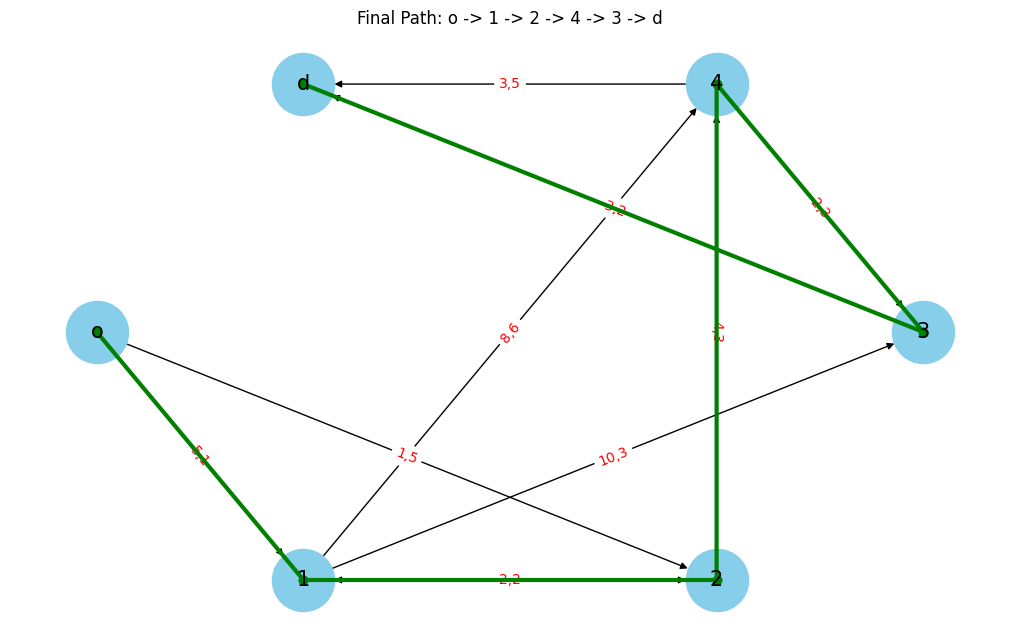

In [2]:
import heapq
import networkx as nx
import matplotlib.pyplot as plt

# Define a modular class for managing the graph
class NetworkGraph:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.initialize_graph()

    def initialize_graph(self):
        # Define the graph edges along with costs and resource consumption (time here)
        edges = [
            ('o', '1', {'cost': 5, 'time': 1}),
            ('o', '2', {'cost': 1, 'time': 5}),
            ('1', '2', {'cost': -4, 'time': 2}),
            ('1', '3', {'cost': 10, 'time': 3}),
            ('1', '4', {'cost': 8, 'time': 6}),
            ('2', '4', {'cost': 4, 'time': 3}),
            ('3', 'd', {'cost': -3, 'time': 2}),
            ('4', '3', {'cost': 2, 'time': 3}),
            ('4', 'd', {'cost': 3, 'time': 5}),
            ('2', '1', {'cost': 2, 'time': 2}),  # Reverse edge 2 -> 1
        ]
        self.graph.add_edges_from(edges)

# Label Class to store information of each path
class Label:
    def __init__(self, node, cost, resource, predecessor):
        self.node = node
        self.cost = cost
        self.resource = resource  # This could be time, fuel, etc.
        self.predecessor = predecessor

    def __lt__(self, other):
        return self.cost < other.cost  # Min-heap based on cost for label sorting

    def __repr__(self):
        return f"Label(node: {self.node}, cost: {self.cost}, resource: {self.resource})"#, predecessor: {self.predecessor})"

# Labeling algorithm for shortest path with resource constraints
class ShortestPathResourceConstraints:
    def __init__(self, graph):
        self.graph = graph
        self.labels = {}  # Store labels for each node
        self.initialize_labels()

    def initialize_labels(self):
        for node in self.graph.graph.nodes:
            self.labels[node] = []  # Empty list for labels at each node

    def add_label(self, node, label):
        # Append a new label to the list of labels for the node
        self.labels[node].append(label)

    def dominate(self, label, labels_at_node):
        # Check if any label in the node dominates the new label
        for existing_label in labels_at_node:
            if existing_label.cost <= label.cost and existing_label.resource <= label.resource:
                return True  # Label is dominated
        return False

    def label_propagation(self, start_node, end_node, resource_limit):
        # Priority queue to process labels in cost order
        pq = []
        initial_label = Label(start_node, 0, 0, None)  # Starting with 0 cost and 0 resource usage
        heapq.heappush(pq, initial_label)
        self.add_label(start_node, initial_label)

        print(f"Initial label at {start_node}: {initial_label}")
        
        while pq:
            current_label = heapq.heappop(pq)
            current_node = current_label.node

            # Propagate the label to neighboring nodes
            for neighbor in self.graph.graph.successors(current_node):
                edge_data = self.graph.graph[current_node][neighbor]
                new_cost = current_label.cost + edge_data['cost']
                new_resource = current_label.resource + edge_data['time']

                # REF (Resource Extension Function) Output
                print(f"\nREF: Propagating label from {current_node} to {neighbor}")
                print(f"    Old label: {current_label}")
                print(f"    Edge cost: {edge_data['cost']}, Edge time: {edge_data['time']}")
                print(f"    New cost: {new_cost}, New resource: {new_resource}")

                # Discard if resource exceeds the limit
                if new_resource > resource_limit:
                    print(f"    Label discarded (resource limit exceeded)")
                    continue

                new_label = Label(neighbor, new_cost, new_resource, current_label)

                # Dominance check
                if self.dominate(new_label, self.labels[neighbor]):
                    print(f"    Label dominated by existing labels at {neighbor}: {new_label}")
                else:
                    print(f"    Label added: {new_label}")
                    heapq.heappush(pq, new_label)
                    self.add_label(neighbor, new_label)

            # Print the labels at each node after each propagation
            self.print_labels()

        return self.extract_optimal_path(end_node)

    def extract_optimal_path(self, end_node):
        # Extract the optimal path by backtracking from the final label at end_node
        if not self.labels[end_node]:
            return None, float('inf'), float('inf')  # No valid path found

        # Find the label with the minimum cost at the end node
        optimal_label = min(self.labels[end_node], key=lambda label: label.cost)
        path = []
        label = optimal_label
        while label:
            path.append(label.node)
            label = label.predecessor
        return list(reversed(path)), optimal_label.cost, optimal_label.resource

    def print_labels(self):
        # Print the current labels at each node
        print("\nCurrent labels at each node:")
        for node, labels in self.labels.items():
            print(f"Node {node}: {[str(label) for label in labels]}")

    def visualize_final_path(self, path):
        # Visualize the final path using matplotlib
        plt.figure(figsize=(10, 6))

        # Use a shell layout or circular layout for better node distribution
        pos = nx.shell_layout(self.graph.graph)
        
        # Draw the directed graph with positions
        nx.draw(self.graph.graph, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=15, arrows=True)
        
        # Draw the edge labels for both directions
        edge_labels = {(u, v): f"{d['cost']},{d['time']}" for u, v, d in self.graph.graph.edges(data=True)}
        nx.draw_networkx_edge_labels(self.graph.graph, pos, edge_labels=edge_labels, font_color='red')

        # Highlight the final path
        for i in range(len(path) - 1):
            plt.plot([pos[path[i]][0], pos[path[i+1]][0]],
                     [pos[path[i]][1], pos[path[i+1]][1]],
                     linestyle='-', marker='o', color='green', lw=3)
        
        plt.title(f"Final Path: {' -> '.join(path)}")
        plt.show()

# Example usage of the algorithm
if __name__ == "__main__":
    # Initialize the graph
    graph = NetworkGraph()

    # Instantiate the SPRC algorithm class
    spprc = ShortestPathResourceConstraints(graph)

    # Find the optimal path from node 'o' to node 'd' with a resource limit of 12 (time limit)
    optimal_path, total_cost, total_resource = spprc.label_propagation('o', 'd', resource_limit=12)
    print(f"\nOptimal Path: {optimal_path}, Cost: {total_cost}, Resource Used: {total_resource}")

    # Visualize only the final path
    spprc.visualize_final_path(optimal_path)
